In [2]:
from numba import jit,njit 
import state_utils

state_utils.set_cohort("Poyet")
state_utils.set_host("an")
state_utils.set_midas_db_type("standard")

import matplotlib.pyplot as plt
import cPickle
import pandas as pd
import state_utils
import config
import figure_utils as fu
import numpy
from itertools import cycle
import random as rand

from random import randint,sample
import seaborn as sns

from sklearn import metrics 
from math import log
from parse_midas_data import parse_good_species_list
import sys
import matplotlib as mpl

good_species = parse_good_species_list()

dates = config.dates
dates_diff = dates.diff()
spec_df = pd.read_csv("%sspecies/relative_abundance.txt.bz2" % config.data_directory,index_col=0,sep="\t")

strain_tot_df = pd.DataFrame(columns=spec_df.columns)

cluster_min_SNV_size = config.cluster_min_SNV_size
strainfinder_dir = config.strainfinder_directory 
dates = config.dates

min_coverage = 5

species = "Bacteroides_uniformis_57318"

sys.stderr.write("Processing %s \n\n" % species)

snp_alignment = pd.read_pickle("%s/%s.strainfinder.p" %  (strainfinder_dir ,species))
samples = pd.read_pickle("%s/%s.strainfinder.samples.p" % (strainfinder_dir ,species))
samples = [s.decode("utf-8") for s in samples]

snp_locations = pd.read_pickle("%s/%s.strainfinder.locations.p" % (strainfinder_dir,species))

label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


Processing Bacteroides_uniformis_57318 



B ovatus am - standard: 2 strains, isolate 1 strain. Paper: 1 strain, with multiple lineages. 

R bromii am - standard: 1 strain, isolate 2 strains.

In [3]:
cluster_As = []
cluster_Ds = []
for snp_idx in range(0,snp_alignment.shape[1]):
    Ds = snp_alignment[:,snp_idx,:].sum(axis=1)
    As = snp_alignment[:,snp_idx,0]
    As = numpy.reshape(As, (1,len(As)))
    Ds = numpy.reshape(Ds, (1,len(Ds)))

    cluster_As.append(As[0])
    cluster_Ds.append(Ds[0])

cluster_As = numpy.array(cluster_As)
cluster_Ds = numpy.array(cluster_Ds)

As = pd.DataFrame(cluster_As,columns=samples,index=snp_locations)
Ds = pd.DataFrame(cluster_Ds,columns=samples,index=snp_locations)

samples_sorted=list(dates.loc[samples].sort_values().index)

As = As.loc[:,samples_sorted]
Ds = Ds.loc[:,samples_sorted]

F = As/Ds

Ass = As
Dss = Ds.loc[Ass.index]


$$d(\hat{f}_{it},\hat{f}_{jt}) = \frac{1}{T} \sum_{t=1}^T \frac{2(D_{it} + D_{jt})(\hat{f}_{it} - \hat{f}_{jt})^2}{{(\hat{f}_{it} + \hat{f}_{jt})(1 - \hat{f}_{it} + 1- \hat{f}_{jt})}}$$

In [4]:
@njit
def mat_nmrt(k,fi,F,di,D,N):
    
    O = numpy.zeros(N)
    
    for i in range(N - k - 1):
        
        j = i + k + 1
        
        fj = F[j]
        dj = D[j]
        
        O[j] = numpy.nanmean((di + dj)*((fi - fj)**2)/((fi + fj)*(1 - fi + 1 - fj)))
        
    return(2.0*O)

In [5]:
@njit
def D_mat_fun1(num,F,D,D_mat):   

    for k in xrange(num - 1):
        
        O = numpy.zeros(num)
        
        di = D[k]
        fi = F[k]
        
        for i in xrange(num - k - 1):

            j = i + k + 1

            fj = F[j]
            dj = D[j]

            O[j] = 2*numpy.nanmean((di + dj)*((fi - fj)**2)/((fi + fj)*(1 - fi + 1 - fj)))        
        
        D_mat[k] = O
    
    return D_mat

In [6]:
@njit
def D_mat_fun2(num,F,D,D_mat_in):   

    for k in xrange(num - 1):
        
        O = numpy.zeros(num)       
        di = D[k]
        ## reverse polarization
        fi = 1-F[k]
        
        for i in xrange(num - k - 1):

            j = i + k + 1
            
            fj = F[j]
            dj = D[j]

            O[j] = 2*numpy.nanmean((di + dj)*((fi - fj)**2)/((fi + fj)*(1 - fi + 1 - fj)))        
        
        D_mat_in[k] = O
    
    return D_mat_in

In [7]:
def return_clus(D_mat_close,Fs_sub):
    D_mat_close_sorted_sum = D_mat_close.sum().sort_values()
    desired_idx = D_mat_close_sorted_sum.index[-1]
    clus_idxs = D_mat_close.loc[D_mat_close[desired_idx]].index
    #clus = Fs_sub.loc[i_list_idx[clus_idxs]]
    
    ### only return indices which are co-clustered w/ at least 25% of other points
    idxtrue = (D_mat_close.loc[clus_idxs,clus_idxs].T.mean() > .5)
    idxtrue = idxtrue[idxtrue].index
    clus_idxs = idxtrue
    clus = Fs_sub.loc[clus_idxs]

        
    return clus,clus_idxs

In [8]:
def drop_clus_idxs(D_mat_close,clus_idxs):
    D_mat_close_out = D_mat_close.drop(clus_idxs).drop(clus_idxs,axis=1)
    return D_mat_close_out

In [9]:
def polarize_clus(clus,clus_idxs,D_mat_1,D_mat_2):
    
    ## polarize whole cluster based on polarization of first cluster element
    clus_to_pol = clus_idxs[numpy.where(D_mat_1.loc[clus_idxs[:1],clus_idxs] > D_mat_2.loc[clus_idxs[:1],clus_idxs])[1]]
    pol_clus = 1 - clus.loc[clus_to_pol]
    clus_non_pol = clus_idxs[numpy.where(D_mat_1.loc[clus_idxs[:1],clus_idxs] < D_mat_2.loc[clus_idxs[:1],clus_idxs])[1]]
    non_pol_plus = clus.loc[clus_non_pol]
    clus_pol = pd.concat([pol_clus,non_pol_plus],ignore_index=True)
    
    return(clus_pol)

In [10]:
@njit
def symmetrize(D_mat):
    for i in range(D_mat.shape[0]-1):
        for j in range(i,D_mat.shape[0]):
            D_mat[j][i] = D_mat[i][j]
    return(D_mat)

In [11]:
min_coverage = 10
Ass = Ass.mask(Dss < min_coverage)

Ass = Ass.mask(Ass == 0)
Ass = Ass.mask(Ass == Dss)
#Ass=Ass.drop("SRR9224141",axis=1)
#Dss=Dss.drop("SRR9224141",axis=1)
Fs = Ass/Dss

Fs = Fs.loc[Fs.notna().T.sum() > int(F.shape[1]/4)]

Ass = Ass.loc[Fs.index]
Dss = Dss.loc[Fs.index]


In [12]:
# Fs=Fs.drop("SRR9224141",axis=1)
# Ass = Ass.loc[Fs.index]
# Dss = Dss.loc[Fs.index]


In [103]:
9280.0/Fs.shape[0]

0.9441448774036015

In [14]:

fss = Ass.values/(Dss.values + (Dss.values == 0))

cluster_As = Ass.values
cluster_Ds = Dss.values
cluster_fs = cluster_As/(cluster_Ds + (cluster_Ds == 0))


Text(0.5,0,'Time (days)')

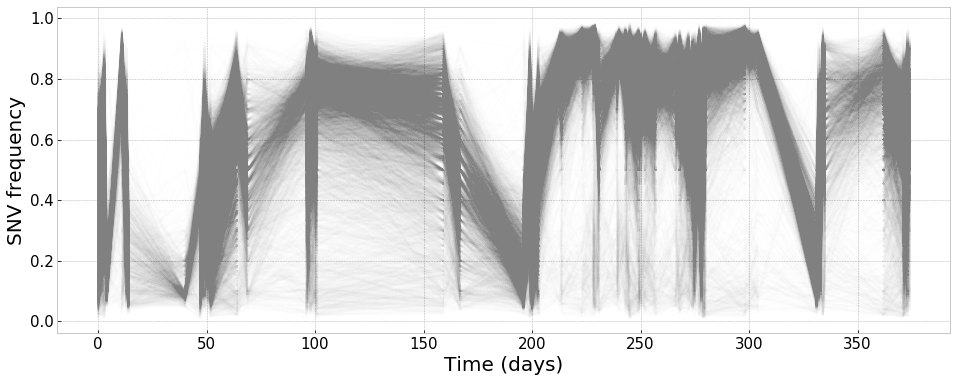

In [104]:
plt.style.use("bmh")
fig,axs = plt.subplots(figsize=(16,6))
#fig.suptitle(fu.get_pretty_species_name(species),style="italic",size=30,x=0.26,y=.95,fontweight=30)
axs.set_facecolor("white")

axs.set_ylabel("SNV frequency",size=20)

axs.plot(dates.loc[Fs.columns],Fs.T.values,color="grey",alpha=.009);

axs.set_xlabel("Time (days)",size=20)

#axs.axvline(15,color="red")

In [15]:
num = min(30000,Fs.shape[0])
i_list = sample(range(Fs.shape[0]),num)
i_list_idx = Fs.iloc[i_list].index

Ass_sub = Ass.loc[i_list_idx]
Dss_sub = Dss.loc[i_list_idx]
Fs_sub = Fs.loc[i_list_idx]

fss_sub = Ass_sub.values/(Dss_sub.values + (Dss_sub.values == 0))

cluster_As_sub = Ass_sub.values
cluster_Ds_sub = Dss_sub.values
cluster_fs_sub = cluster_As_sub/(cluster_Ds_sub + (cluster_Ds_sub == 0))


In [16]:
D_mat = numpy.zeros([num,num])
%time D_mat_1 = D_mat_fun1(num,fss_sub,cluster_Ds_sub,D_mat)
D_mat = numpy.zeros([num,num]) 
%time D_mat_2 = D_mat_fun2(num,fss_sub,cluster_Ds_sub,D_mat)

CPU times: user 41.6 s, sys: 228 ms, total: 41.9 s
Wall time: 41.9 s
CPU times: user 48.4 s, sys: 217 ms, total: 48.6 s
Wall time: 48.6 s


In [17]:
D_mat = numpy.fmin(D_mat_1,D_mat_2)

In [18]:
D_mat_1 = pd.DataFrame(D_mat_1,index=Fs_sub.index,columns=Fs_sub.index)
D_mat_2 = pd.DataFrame(D_mat_2,index=Fs_sub.index,columns=Fs_sub.index)

In [19]:
D_mat = symmetrize(D_mat)

In [72]:
D_mat_close = pd.DataFrame(D_mat < 10) 

/u/home/r/rwolff/.conda/envs/strain_stability_env/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [73]:
D_mat_close.index = Fs_sub.index
D_mat_close.columns = Fs_sub.index

In [74]:
clus1,clus_idxs_1 = return_clus(D_mat_close,Fs_sub)
clus1_pol = polarize_clus(clus1,clus_idxs_1,D_mat_1,D_mat_2)
D_mat_close_1 = drop_clus_idxs(D_mat_close,clus_idxs_1)

clus2,clus_idxs_2 = return_clus(D_mat_close_1,Fs_sub)
clus2_pol = polarize_clus(clus2,clus_idxs_2,D_mat_1,D_mat_2)
D_mat_close_2 = drop_clus_idxs(D_mat_close_1,clus_idxs_2)

clus3,clus_idxs_3 = return_clus(D_mat_close_2,Fs_sub)
clus3_pol = polarize_clus(clus3,clus_idxs_3,D_mat_1,D_mat_2)
D_mat_close_3 = drop_clus_idxs(D_mat_close_2,clus_idxs_3)

clus4,clus_idxs_4= return_clus(D_mat_close_3,Fs_sub)
clus4_pol = polarize_clus(clus4,clus_idxs_4,D_mat_1,D_mat_2)
D_mat_close_4 = drop_clus_idxs(D_mat_close_3,clus_idxs_4)

clus5,clus_idxs_5 = return_clus(D_mat_close_4,Fs_sub)
clus5_pol = polarize_clus(clus5,clus_idxs_5,D_mat_1,D_mat_2)
D_mat_close_5 = drop_clus_idxs(D_mat_close_4,clus_idxs_5)

clus6,clus_idxs_6= return_clus(D_mat_close_5,Fs_sub)
clus6_pol = polarize_clus(clus6,clus_idxs_6,D_mat_1,D_mat_2)
D_mat_close_6 = drop_clus_idxs(D_mat_close_2,clus_idxs_6)

IndexError: index -1 is out of bounds for axis 0 with size 0

In [75]:
(clus1_pol.shape,clus2_pol.shape,clus3_pol.shape,clus4_pol.shape,clus5_pol.shape,clus6_pol.shape)

((9280, 55), (521, 55), (24, 55), (0, 55), (108, 55), (75, 55))

(0, 1)

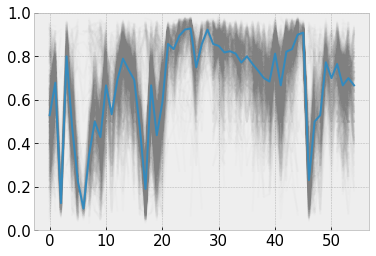

In [77]:
plt.plot(clus1_pol.sample(1000).T.values,color="grey",alpha=.02);
plt.plot(clus1_pol.median().values)
plt.ylim([0,1])


(0, 1)

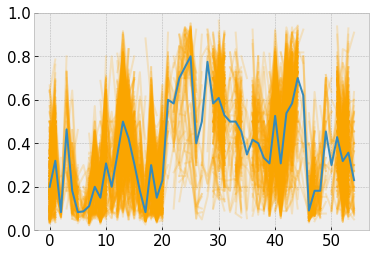

In [71]:
plt.plot(clus2_pol.sample(1000).T.values,color="orange",alpha=.2);
plt.plot(clus2_pol.median().values)
plt.ylim([0,1])

(0, 1)

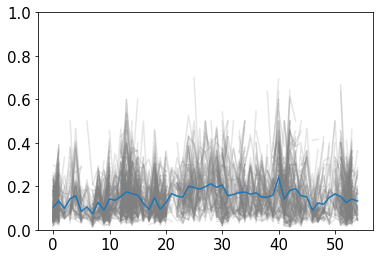

In [26]:
plt.plot(clus3_pol.sample(400).T.values,color="grey",alpha=.2);
plt.plot(clus3_pol.mean().values)
plt.ylim([0,1])

(0, 1)

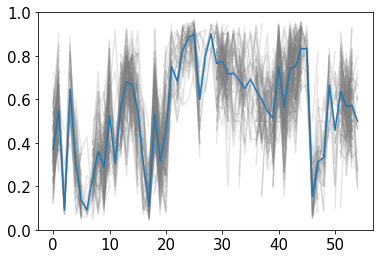

In [27]:
plt.plot(clus4_pol.sample(150).T.values,color="grey",alpha=.2);
plt.plot(clus4_pol.median().values)
plt.ylim([0,1])

In [ ]:
i = 1
for clus in [clus1_pol, clus2_pol, clus3_pol,clus4_pol,clus5_pol,clus6_pol]:    
    print(clus)
    if clus.shape[0] > cluster_min_SNV_size:
        clus.to_csv("/u/home/r/rwolff/strain_stability_revisions/strainstability/analysis/clusters/Poyet/%s/%s/%s_cluster_%s.csv.gz" % 
                   (config.host,species,species,str(i)),compression='gzip')
        i+=1


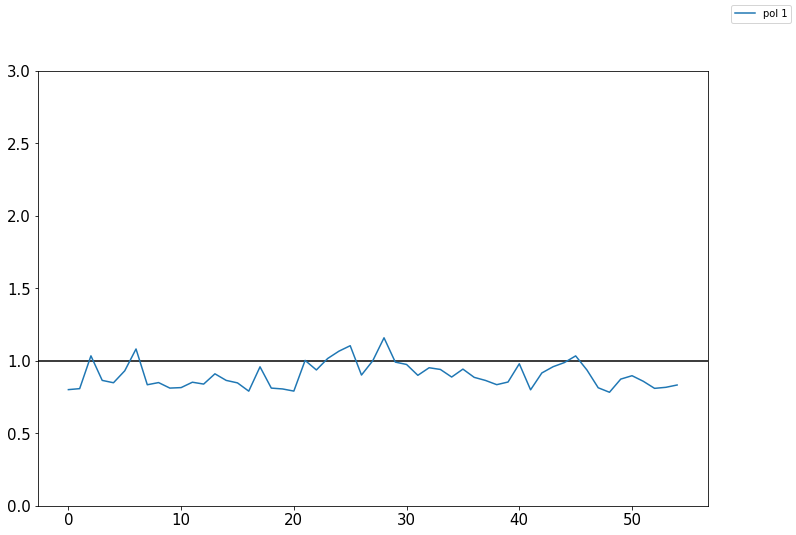

In [32]:
fig,ax = plt.subplots(figsize=(12,8))
ax.axhline(1,color="k")

#ax.plot((1-clus1.median().values) + clus2.median().values,label="pol 1")
#ax.plot(clus1.median().values + (1-clus2.median().values),label="pol 2")

ax.plot((1-clus1_pol.median().values)  + (clus2_pol.median().values) + clus3_pol.median().values,label="pol 1")
#ax.plot(clus1_pol.median().values + (1-clus2_pol.median().values) + clus3_pol.median().values,label="pol 2")
#ax.plot((clus1_pol.median().values) + (clus2_pol.median().values) + (clus3_pol.median().values),label="pol 3")
#ax.plot((1-clus1_pol.median().values) + (clus2_pol.median().values) + (1-clus3_pol.median().values),label="pol 4")

ax.set_ylim([0,3])
fig.legend()


In [ ]:
fig,ax = plt.subplots(figsize=(12,8))

ax.plot(1-clus1_pol.T.values,color="grey",alpha=.02)
ax.plot(1-clus1_pol.median().values,lw=1,zorder=10,color="yellow");

ax.plot(clus2_pol.T.values,color="grey",alpha=.02);
ax.plot(clus2_pol.median().values,lw=1,zorder=10,color="orange");

ax.plot(1-clus3_pol.T.values,color="grey",alpha=.02);
ax.plot(1-clus3_pol.median().values,lw=1,zorder=10,color="green");

#ax.plot(clus5.sample(clus5.shape[0]).T.values,color="red",alpha=.002);
#ax.plot(clus5.median().values,lw=1,zorder=10,color="green");

In [78]:
data_dir = config.data_directory

In [79]:
snps_info_loc = "%ssnps/%s/snps_info.txt.bz2" % (data_dir,species)

In [80]:
snps_info = pd.read_csv(snps_info_loc,iterator=True,sep="\t")

In [81]:
u=snps_info.get_chunk(int(1e7))

In [82]:
clus1_idxs_m = [e[0] + str(e[1]) for e in clus_idxs_1]
clus2_idxs_m = [e[0] + str(e[1]) for e in clus_idxs_2]
clus3_idxs_m = [e[0] + str(e[1]) for e in clus_idxs_3]

In [83]:
u["snv_id"] = [x.split("|")[0] + str(x.split("|")[1]) for x in u["site_id"]]

In [84]:
u.index = u["snv_id"]

In [85]:
u_clus1=u.loc[clus1_idxs_m]

[]

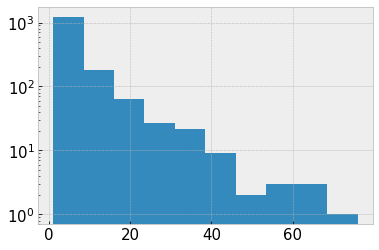

In [86]:
plt.hist(u_clus1["gene_id"].value_counts().values)
plt.semilogy()

In [ ]:
u_clus2=u.loc[clus2_idxs_m]
u_clus2["gene_id"].value_counts()

In [ ]:
u_clus3=u.loc[clus3_idxs_m]
u_clus3["gene_id"].value_counts()

In [87]:
#u_clus = pd.concat([u_clus1,u_clus2,u_clus3])
u_clus = u_clus1

In [88]:
u_clus["gene_id"].value_counts()[:10]

411479.10.peg.1755    76
411479.10.peg.1120    68
411479.10.peg.1137    63
411479.10.peg.3437    62
411479.10.peg.1284    56
411479.10.peg.578     56
411479.10.peg.565     55
411479.10.peg.2812    50
411479.10.peg.227     46
411479.10.peg.529     44
Name: gene_id, dtype: int64

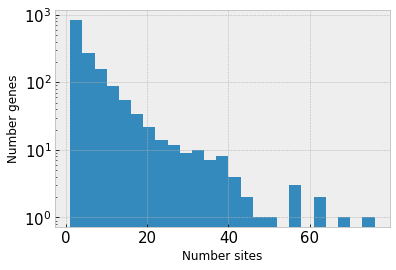

In [89]:
plt.hist(u_clus["gene_id"].value_counts().values,bins=25)
plt.semilogy()
plt.xlabel("Number sites")
plt.ylabel("Number genes");

In [90]:
u_clus_cp = u_clus.copy()

In [91]:
u_cp = u.copy()

In [92]:
u_clus_cp["gene_id"].value_counts().shape

(1546,)

In [93]:
(u_clus_cp["gene_id"].value_counts() > 5).sum()

502

In [94]:
i = 0
gene_rate_dic = {}
vc = u_clus_cp["gene_id"].value_counts()
for gene in vc.index:
    if vc.loc[gene] > 5:
        x1=u_clus_cp.loc[u_clus_cp["gene_id"] == gene]["site_type"]
        g=x1.value_counts()
        #u_clus_cp.drop(x1.index,inplace=True)

        x2 = u_cp.loc[u_cp["gene_id"] == gene]["site_type"]
        gg = x2.value_counts()
        #u_cp.drop(x2.index,inplace=True)   

        num_sites = x1.shape[0]

        if "1D" not in g.keys():
            g["1D"] = 0
        if "4D" not in g.keys():
            g["4D"] = 1
        if "1D" not in gg.keys():
            gg["1D"] = 1
        if "4D" not in gg.keys():
            gg["4D"] = 1    

        dN = (1.0*g["1D"])/gg["1D"]
        dS = (1.0*g["4D"])/(gg["4D"] + (gg["4D"] == 0))

        gene_rate_dic[gene] = (num_sites,dN/(dS + (dS == 0)),dS)

        i+=1 
        if i%10 == 0:
            print(i)
    

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500


In [95]:
rate_df = pd.DataFrame(gene_rate_dic,index=["num_sites","dN/dS","dS"]).T

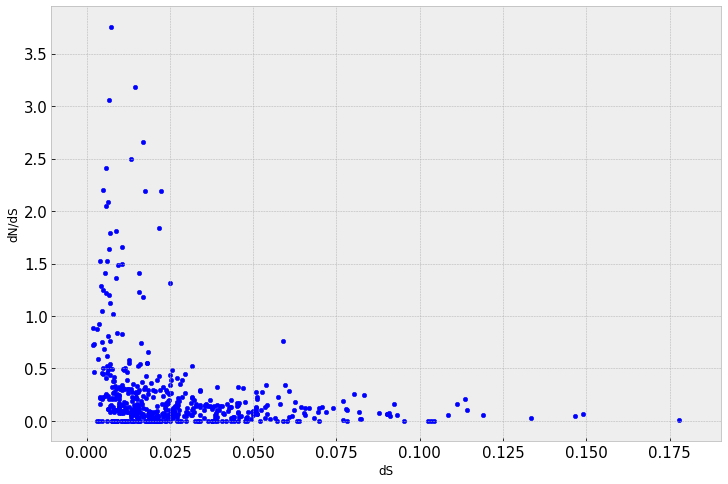

In [96]:
fig,ax = plt.subplots(figsize=(12,8))
rate_df.plot.scatter(x="dS",y="dN/dS",ax=ax)
#ax.semilogy()

In [97]:
import parse_midas_data
import core_gene_utils
import parse_patric

In [98]:
genome_ids=parse_midas_data.get_ref_genome_ids(species)

In [99]:
non_shared_genes = core_gene_utils.parse_non_shared_reference_genes(species)

In [100]:
gene_descriptions=parse_patric.load_patric_gene_descriptions(genome_ids, non_shared_genes)
gene_categories, gene_category_map = parse_patric.cluster_patric_gene_descriptions(gene_descriptions)

In [101]:
kegg_ids=parse_patric.load_kegg_annotations(genome_ids)

In [102]:
for ind in rate_df.index:
    if rate_df.loc[ind,"dN/dS"] > .5:
        print(rate_df.loc[ind,"dN/dS"],kegg_ids[ind])

(0.5261437908496732, [['', '']])
(1.3614457831325302, [['', '']])
(2.6598360655737707, [['', '']])
(2.4930747922437675, [['', '']])
(2.1923076923076925, [['', '']])
(0.7508896797153024, [['', '']])
(2.0842696629213484, [['', '']])
(1.2518440463645941, [['', '']])
(1.84, [['', '']])
(0.812664907651715, [['', '']])
(3.7551020408163263, [['', '']])
(0.5792933442892358, [['', '']])
(1.4861111111111112, [['', '']])
(2.043541364296081, [['', '']])
(1.2016021361815754, [['', '']])
(0.832214765100671, [['', '']])
(1.640287769784173, [['', '']])
(1.2272727272727273, [['', '']])
(0.5909402882635553, [['', '']])
(0.5031446540880503, [['', '']])
(0.6533864541832669, [['', '']])
(0.7640449438202247, [['', '']])
(3.184615384615385, [['', '']])
(0.5063613231552163, [['', '']])
(1.811023622047244, [['', '']])
(1.3186813186813187, [['', '']])
(2.1951219512195124, [['', '']])
(0.508130081300813, [['', '']])
(0.875, [['', '']])
(0.5263157894736842, [['', '']])
(1.052121212121212, [['00860', 'Porphyrin an